In [1]:
# !pip install pip --upgrade
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
# !pip install pyopenssl --upgrade
# !pip install --upgrade smart_open
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

from datetime import datetime
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

In [2]:
%%time
embeddings_dict_6B_50D = {}
with open("glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-50]).lower().strip()
        vector = np.asarray(values[-50:], "float32")
        embeddings_dict_6B_50D[word] = vector
        
def vectorize_text_50(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 4.11 s


In [3]:
%%time
embeddings_dict_6B_100D = {}
with open("glove.6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-100]).lower().strip()
        vector = np.asarray(values[-100:], "float32")
        embeddings_dict_6B_100D[word] = vector
        
def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 7.62 s


In [4]:
def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [5]:
%%time
cfpb_df = pd.read_csv("CFPB with Duplicate Marked NEW.csv")
print(cfpb_df.shape)

<timed exec>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


(1300361, 24)
Wall time: 24.4 s


In [6]:
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1083240, 24)


<AxesSubplot:ylabel='Frequency'>

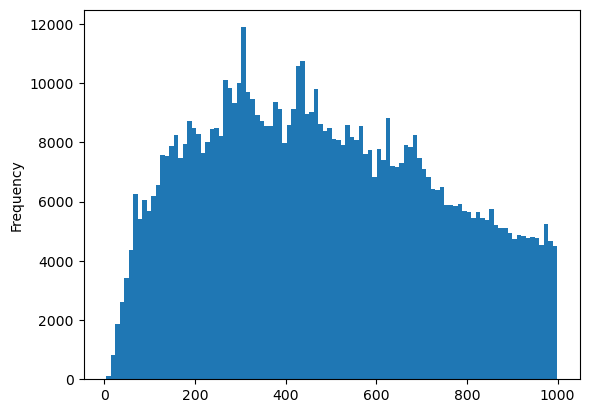

In [7]:
cfpb_df[cfpb_df['narr_len']<1000]['narr_len'].plot(kind='hist', bins=100) 

In [8]:
cfpb_df[(cfpb_df['narr_len']<300)&(cfpb_df['narr_len']>200)].sample(10)[['Consumer complaint narrative','Product']]

,Consumer complaint narrative,Product
198880,"CHIME banking has closed my account due to a negative balance, although multiple fraudulent charges occurred on my account. Specialist were aware instead refused to investigate, now I've suffered from lost funds, and access to my checking and savings account",Checking or savings account
779869,"these two accounts appear on my credit report, they are hurting me, they don't belong to me Identity Theft WF/XXXX Account XXXX : XXXX This is not mine. \n\n2. Identity Theft WF CRD SVC Account Number : XXXX This is not mine.","Credit reporting, credit repair services, or other personal consumer reports"
1187696,Received a chime debit card in the mail that I never applied for under my old name. \nOn another day I also received another debit card in my new name that I never requested that card is under XXXX XXXX XXXX XXXX,Credit card or prepaid card
11044,Disputed with the company on XX/XX/2021. Company received my dispute on XX/XX/2021. It is now XX/XX/2021 and I have yet to hear anything back from the company. The FCRA gives the company 30 days to respond and I haven't gotten a response for this medical bill,Debt collection
631646,I have been unemployed since XXXX : Navient has been sending me harassing letters and calls every week saying they will take me to court if I ca n't come up with {$300.00} a month for their payments. I have contacted this company several times to tell them I am unemployed and have still received,Student loan
965344,"I just checked my credit report today on credit karma and i have a new loan that appeared on my credit report "" XXXX XXXX XXXX for XXXX ''. The message said as of XXXX 2016 this has been added. I am confused as to why this is a new account added on my credit report",Credit reporting
994416,Experian on their own placed a security freeze on my account and I have demanded that they remove it. They refuse to do so and expect me to provide a PIN that I don't have. I will not jump through their stupid hoops to get something removed that should not have been placed there in the first place.,"Credit reporting, credit repair services, or other personal consumer reports"
924476,"After reviewing my credit report there's misleading information that appears on there, more specifically an account that does not belong to me, it looks like this account was opened fraudulently on XXXX.","Credit reporting, credit repair services, or other personal consumer reports"
808073,Date : XX/XX/2019 Company : Portfolio Recovery Original Creditor : XXXX XXXX XXXX Original Balance : {$5200.00} Action taken : I filed a dispute with Portfolio Recovery The dispute ended XX/XX/2019 Result : Portfolio Recovery declined the dispute request,Debt collection
1125135,"I only fell a few weeks behind and they are calling my employer, who I never gave permission to call. I have instructed them that the only valid number to call is my home, and they must discontinue calling my place of work and my family.",Consumer Loan


In [9]:
cfpb_df['narr_len'].quantile(.16)

274.0

In [10]:
cfpb_df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'clean_narr', 'dupi_id', 'dupi_len'],
      dtype='object')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

def plot_proba_distribution(y_pred_proba, classes):
    for idx, _class in enumerate(classes):
        sns.kdeplot(y_pred_proba[:, idx], label=_class)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Probability distributions of classes')
    plt.legend()
    plt.show()
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
def grid_search_svm(df, column_name):
    for unique_value in df[column_name].unique():
        if True:
#         if unique_value in ['Checking or savings account', 
#                             "Money transfer, virtual currency, or money service", 
#                             'Debt collection']:
            try:
                print(f"now training binary classification model for {unique_value}")
                # create target
                df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
                print(df['is_'+ unique_value].value_counts())

                # vectorize
                df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

                # create x and y
                X = list(df['glove_50_features'])
                y = df['is_'+ unique_value]

                # split data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

                # Apply Balancing with ADASYN
                # ada = ADASYN(random_state=42)
                # X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
                rus = RandomUnderSampler(random_state=42)
                X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
                print(y_train_resampled.value_counts())

                for data_size in [5000, 10000]:#, 10000, 20000]:
                    # Randomly select x samples for training
                    sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
                    X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
                    y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

                    # grid search
                    # param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [5,10,20]}
                    param_grid = {
                        'n_estimators': [200, 300], #[150,200],# [100, 200, 300], 
                        'max_depth': [10, 15, 25],#[25, 30],# [20, 30, 40], 
                        'min_samples_split': [10],#[5, 10],
                        'bootstrap': [True], # [True, False],
                        'max_features': ['sqrt']# ['sqrt', 'log2', 0.5, 0.7]
                    }

                    # initialize random forest and grid
                    rf = RandomForestClassifier(class_weight='balanced')
                    rf.classes_ = np.array([0, 1])
                    grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=4, n_jobs=-1)
                    # fitting the grid
                    grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

                    # evaluate
                    y_pred = grid.predict(np.array(X_test).tolist())
                    print(f1_score(y_test, y_pred, average='weighted'))
                    print(classification_report(y_test, y_pred))
                    print("The best parameters:", grid.best_params_)
                    print("Data size:", data_size)

                    results = grid.cv_results_
                    for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
                        print(params, "has a score of", mean_test_score)
                    print("-----------------------------------------------------------------------")
                print("**************************************************************************")
            except:
                pass

In [12]:
# define a dictionary to map the old categories to the new ones
category_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting and repair services",
    "Credit reporting": "Credit reporting and repair services",
    "Credit card or prepaid card": "Credit and prepaid cards",
    "Credit card": "Credit and prepaid cards",
    "Prepaid card": "Credit and prepaid cards",
    "Checking or savings account": "Banking services",
    "Bank account or service": "Banking services",
    "Money transfer, virtual currency, or money service": "Money transfer and virtual currency services",
    "Money transfers": "Money transfer and virtual currency services",
    "Virtual currency": "Money transfer and virtual currency services",
    "Vehicle loan or lease": "Loans and leases",
    "Consumer Loan": "Loans and leases",
    "Payday loan, title loan, or personal loan": "Short-term and personal loans",
    "Payday loan": "Short-term and personal loans",
    "Other financial service": "Other financial service",
    "Mortgage": "Mortgage",
    "Student loan": "Student loan",
    "Debt collection": "Debt collection"
}

# apply the mapping to the 'product' column
cfpb_df['combined_product'] = cfpb_df['Product'].map(category_mapping)
cfpb_df[(cfpb_df['narr_len']>500)].combined_product.value_counts(normalize=True)

Credit reporting and repair services            0.386616
Debt collection                                 0.159558
Mortgage                                        0.125267
Credit and prepaid cards                        0.120523
Banking services                                0.086766
Student loan                                    0.037997
Loans and leases                                0.034030
Money transfer and virtual currency services    0.032370
Short-term and personal loans                   0.016557
Other financial service                         0.000315
Name: combined_product, dtype: float64

In [13]:
grid_search_svm(cfpb_df[(cfpb_df['narr_len']>500)].copy(), "combined_product")

now training binary classification model for Credit reporting and repair services
0    428156
1    269867
Name: is_Credit reporting and repair services, dtype: int64
0    242951
1    242951
Name: is_Credit reporting and repair services, dtype: int64
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8562452765653222
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     42887
           1       0.81      0.82      0.82     26916

    accuracy                           0.86     69803
   macro avg       0.85      0.85      0.85     69803
weighted avg       0.86      0.86      0.86     69803

The best parameters: {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Data size: 5000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8452743812380767
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt'

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8812550715293492
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     63701
           1       0.37      0.86      0.51      6102

    accuracy                           0.86     69803
   macro avg       0.68      0.86      0.72     69803
weighted avg       0.93      0.86      0.88     69803

The best parameters: {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Data size: 10000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8492495746197747
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300} has a score of 0.8482364778985219
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8529908161187999
{'bootstrap': True, 'max_d

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.8227745306324746
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     61354
           1       0.35      0.83      0.49      8449

    accuracy                           0.79     69803
   macro avg       0.66      0.81      0.68     69803
weighted avg       0.90      0.79      0.82     69803

The best parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Data size: 10000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.7990783643617068
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300} has a score of 0.799098477147179
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8051866796150199
{'bootstrap': True, 'max_de

0.9028063761737217
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     67140
           1       0.20      0.85      0.33      2663

    accuracy                           0.87     69803
   macro avg       0.60      0.86      0.63     69803
weighted avg       0.96      0.87      0.90     69803

The best parameters: {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Data size: 5000
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8471831586045744
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300} has a score of 0.8485814171613415
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200} has a score of 0.8519866589125519
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, '

In [13]:
def train_rf(df, column_name):
    model_dict = {}
    for unique_value in df[column_name].unique():
        # Create target
        df['is_'+ unique_value] = df[column_name].apply(lambda x: 1 if x==unique_value else 0)
        
        value_counts = df['is_'+ unique_value].value_counts()

        # Check if the minority class is at least 1% of the majority class
        if min(value_counts)/max(value_counts) < 0.05:
            print(f"Skipping training binary classification model for {unique_value} due to class imbalance.")
            continue
        print(value_counts)
        print(f"Now training binary classification model for {unique_value}")

        # Create features
        df['glove_50_features'] = df['clean_narr'].apply(vectorize_text_100)

        X = list(df['glove_50_features'])
        y = df['is_'+ unique_value]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        # Apply ADASYN
        ada = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)

        # Randomly select 15000 samples for training
        sample_idx = np.random.choice(len(X_train_resampled), 30000, replace=False)
        X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
        y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

        # Initialize Random Forest
        rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=10, max_features='auto')
        rf.classes_ = np.array([0, 1])

        # Fitting the model
        rf.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

        # Evaluate
        y_pred = rf.predict(np.array(X_test).tolist())
        print(classification_report(y_test, y_pred))
        print(rf.classes_)
        
        # Get the probabilities
        y_pred_proba = rf.predict_proba(np.array(X_test).tolist())

        # Plot the distribution
        plot_proba_distribution(y_pred_proba, rf.classes_)

        model_dict[f"{unique_value}_clf"] = rf
        print("**************************************************************************")
    return model_dict

In [ ]:
# grid_search_svm(cfpb_df, "Product")
product_models = train_svm(cfpb_df, "Product")

0    632832
1    450408
Name: is_Credit reporting, credit repair services, or other personal consumer reports, dtype: int64
now training binary classification model for Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
cfpb_df_long = cfpb_df[cfpb_df['narr_len']>275].copy()
long_product_models = train_svm(cfpb_df_long, "Product") # Did'nt see huge improvements

In [ ]:
issue_models = train_svm(cfpb_df, "Issue")

In [ ]:
long_issue_models = train_svm(cfpb_df_long, "Issue") # see improvements

In [70]:
import pickle
# Save each model
for model_name, model in product_models.items():
    filename = f"Product {model_name}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [71]:
# for model_name, model in long_product_models.items():
#     filename = f"Product {model_name} long.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [72]:
# for model_name, model in issue_models.items():
#     filename = f"Issue {model_name}.pkl"
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)

In [73]:
for model_name, model in long_issue_models.items():
    filename = f"Issue {model_name} long.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [74]:
vectorized_text = vectorize_text("i called the collection agency for my debt verification. but they cant verify it. and it wasnt on their system. and said that they will remove it on my credit report. its been 2 months i believe but its still shows on my credit as open and with negative information.")

x = product_models['Credit reporting, credit repair services, or other personal consumer reports_clf'].predict_proba([vectorized_text])
print(x)

[[0.65038987 0.34961013]]
